# TP 2 - Procesamiento del Lenguaje Natural

## Librerias y Funciones


In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix
from mlxtend.preprocessing import DenseTransformer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from langdetect import detect
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding, GRU
from tensorflow.keras.layers import Input
from nltk.tokenize.toktok import ToktokTokenizer
from emoji import emoji_count, demojize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
import os
from sklearn.tree import DecisionTreeClassifier

In [55]:
def mostrar_scores(y_test: np.ndarray, y_prediccion: np.ndarray):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

def cantidad_de_palabras(review):
    return len(review.split())

## Analisis Exploratorio

Comenzamos con el analisis exploratorio de los datos, para ello vamos a cargar los datos y a ver como estan distribuidos.

In [4]:
df = pd.read_csv('datasets/train.csv', sep=',')
df.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


Podemos observar que contamos con un total de 50000 reviews

In [239]:
df.shape

(50000, 3)

Como se puede observar en el siguiente grafico, veremos la distribucion del sentimiento de las reviews, con mitad de las mismas positivas y mitad de reviews negativas.

In [240]:
sns.countplot(df['sentimiento'], color='blue')
plt.xlabel('Canttidad de reviews')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

ValueError: could not convert string to float: 'positivo'

A continuacion vamos a adentrarnos a analizar las caracteristicas de las reviews en general.

En primer lugar vamos a analizar el dataset para ver si contiene emojis

In [241]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

,cantidad_emojis,cantidad_filas
0,0,49995
1,1,5


Por otro lado, buscaremos saber como se distribuye la longitud de las reviews. Para ello, vamos a calcular la cantidad de palabras de cada review.

In [242]:
df['cantidad_de_palabras'] = df['review_es'].apply(cantidad_de_palabras)

In [243]:
df['cantidad_de_palabras'].describe()

count    50000.000000
mean       237.233680
std        179.529306
min          6.000000
25%        123.000000
50%        172.000000
75%        293.000000
max       2450.000000
Name: cantidad_de_palabras, dtype: float64

Ahora realizaremos un analisis grafico de la cantidad de palabras para ver si encontramos ciertas tendencias.

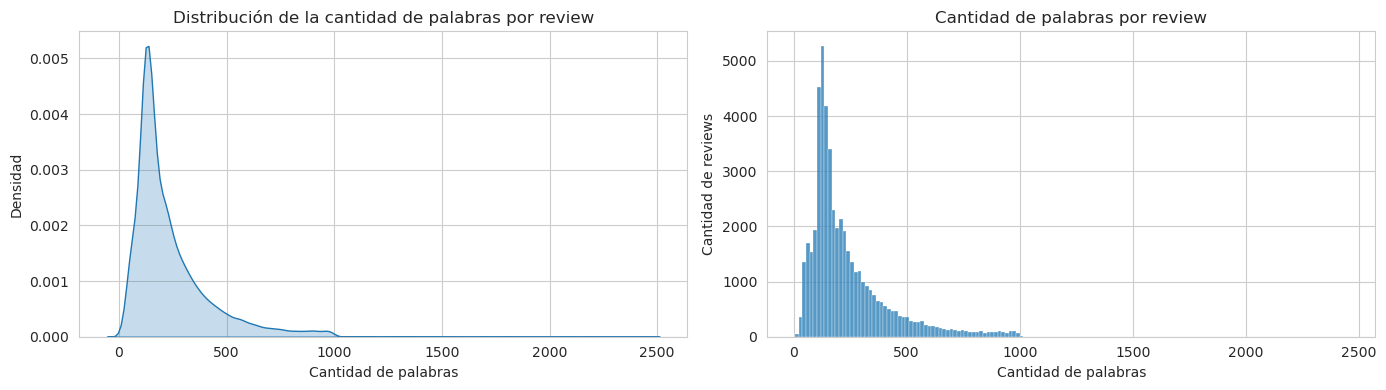

In [15]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['cantidad_de_palabras'],  ax=ax2, bins=150, kde=False).set_title('Distribución de la cantidad de palabras por review')
ax2.set_xlabel('Cantidad de palabras')
ax2.set_ylabel('Cantidad de reviews')

plt.title('Cantidad de palabras por review')
plt.tight_layout()
plt.show()

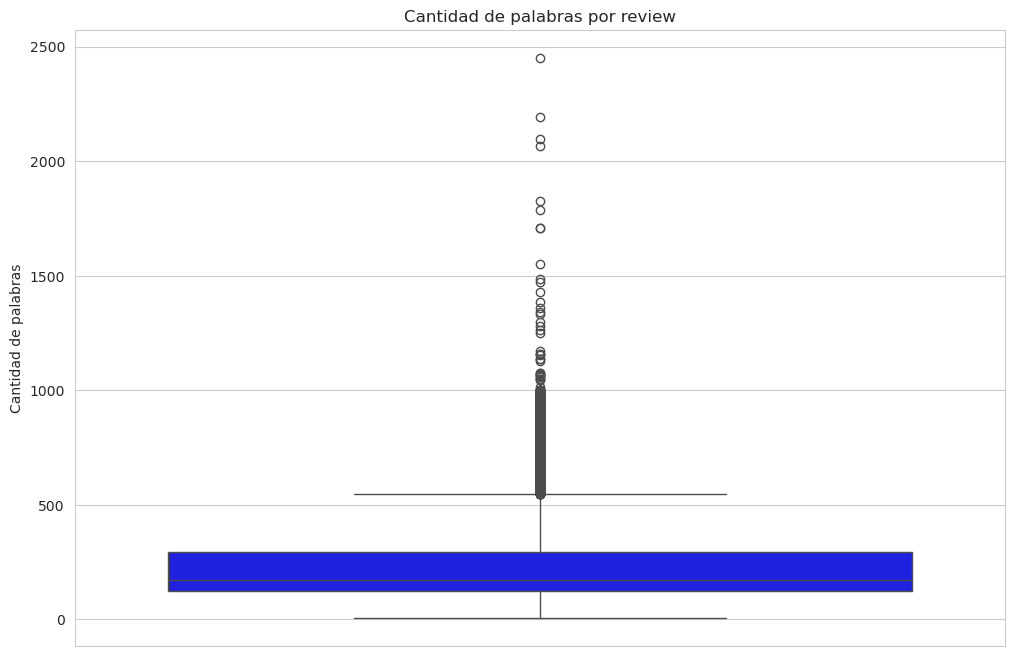

In [16]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(df['cantidad_de_palabras'], color='blue')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.show()

Como se puede observar en el boxplot de arriba, contamos con bastantes outliers en la cantidad de palabras de las reviews. Por lo tanto, vamos a utilizar otras tecnicas como el z-score y z-score modificado para ver cuantas reviews serian consideradas outliers.

In [17]:
df['zscore'] = (df['cantidad_de_palabras'] - df['cantidad_de_palabras'].mean()) / df['cantidad_de_palabras'].std()

In [18]:
df_z_score = df[(df['zscore'] > 3) | (df['zscore'] < -3)]
df_z_score.shape

(1240, 5)

In [19]:
mediana_cantidad_de_palabras=np.median(df['cantidad_de_palabras'])
MAD=np.median(np.absolute(df['cantidad_de_palabras']-mediana_cantidad_de_palabras))

df['zm_cantidad_de_palabras']=(df['cantidad_de_palabras'] - mediana_cantidad_de_palabras)*0.6745/MAD
df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)].shape

(4320, 6)

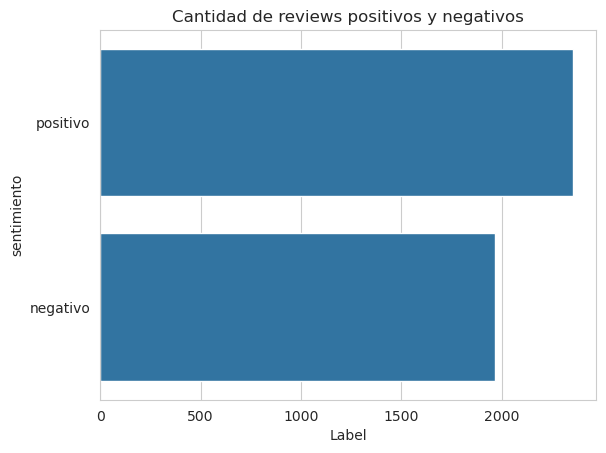

In [20]:
sns.countplot(df[np.absolute(df['zm_cantidad_de_palabras'] > 3.5)]['sentimiento'])
plt.xlabel('Label')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

Por otro lado, creimos que tambien seria interesante ver como se distribuye la cantidad de palabras de las reviews en funcion de su sentimiento.

/tmp/ipykernel_8771/2888992444.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')


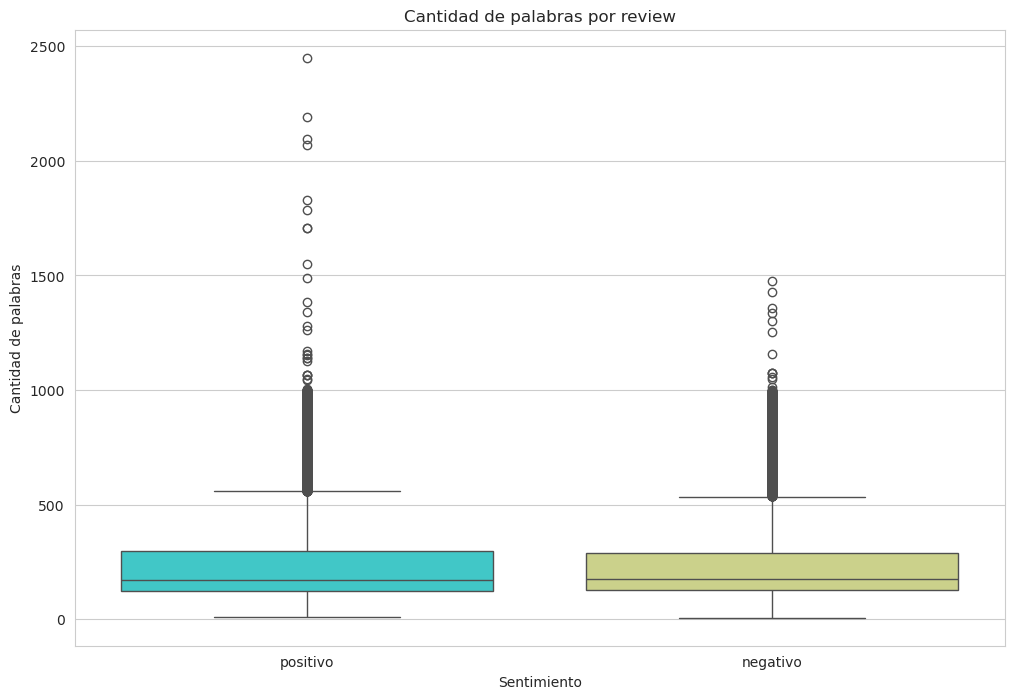

In [21]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')
plt.show()

Dejando de lado a los outliers, se puede ver que la cantidad de palabras es muy pareja entre las reviews positivas y negativas.

Ademas, otro factor que creemos que puede ser importante es la cantidad de caracteres de las reviews. Por lo tanto, vamos a calcular la cantidad de caracteres de cada review. Esta informacion nos servira luego a la hora de traducir los reviews ya que la API de Google Translate tiene un limite de caracteres por request de 5000 caracteres.

In [22]:
df['longitud_review'] = df['review_es'].apply(lambda x: len(str(x)))
df['longitud_review'].describe()

count    50000.000000
mean      1398.058240
std       1037.688582
min         39.000000
25%        747.000000
50%       1037.000000
75%       1711.000000
max      13465.000000
Name: longitud_review, dtype: float64

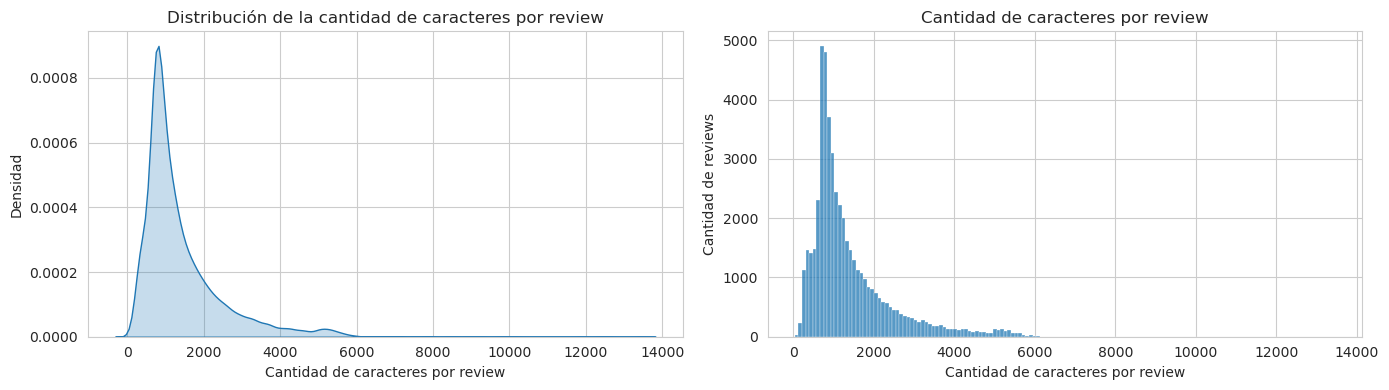

In [23]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.kdeplot(df['longitud_review'], fill=True, ax=ax1).set_title('Distribución de la cantidad de caracteres por review')
ax1.set_ylabel('Densidad')
ax1.set_xlabel('Cantidad de caracteres por review')

sns.histplot(df['longitud_review'],  ax=ax2, bins=150, kde=False).set_title('Cantidad de caracteres por review')
ax2.set_xlabel('Cantidad de caracteres por review')
ax2.set_ylabel('Cantidad de reviews')

plt.tight_layout()
plt.show()

Luego, verificamos que no haya reviews duplicadas. En caso positivo, durante el preprocesamiento las eliminaremos.

In [24]:
df['review_es'].duplicated().sum()

401

Otro analisis importante es verificar si hay revies que esten en otro idioma ya que distorsionarian fuertemente el analisis. En caso positivo, durante el preprocesamiento las intentaremos traducir al castellano. La otra opcion seria eliminarlas, veremos cual nos brinda mejores resultados.

In [246]:
if os.path.isfile('datasets/train_con_idioma.csv'):
    df = pd.read_csv('datasets/train_con_idioma.csv', sep=',')
else:
    df['idioma'] = df['review_es'].apply(detect)
df['idioma'].value_counts()

es    48180
en     1817
fr        1
it        1
id        1
Name: idioma, dtype: int64

In [247]:
if not os.path.isfile('datasets/train_con_idioma.csv'):
    df.to_csv('datasets/train_con_idioma.csv', index=False)

Tambien, vamos a verificar la cantidad de reviews que contienen numeros, ya que si esta entre 1 y 10, nos puede indicar informacion relevante de la puntuacion de la pelicula.

In [22]:
df['contiene_numeros'] = df['review_es'].str.contains(r'\d', regex=True)

conteo_contiene_numeros = df['contiene_numeros'].sum()

print(f"Cantidad de reseñas que contienen números: {conteo_contiene_numeros}")

Cantidad de reseñas que contienen números: 27609

Conteo de 'contiene_numeros':
contiene_numeros
True     27609
False    22391
Name: count, dtype: int64


In [ ]:
df['contiene_numeros'] = df['review_es'].str.contains(r'\d', regex=True)

conteo_contiene_numeros = df['contiene_numeros'].sum()

print(f"Cantidad de reseñas que contienen números: {conteo_contiene_numeros}")

Ahora vamos a graficar la cantidad de reviews que contienen numeros de nuestro interes

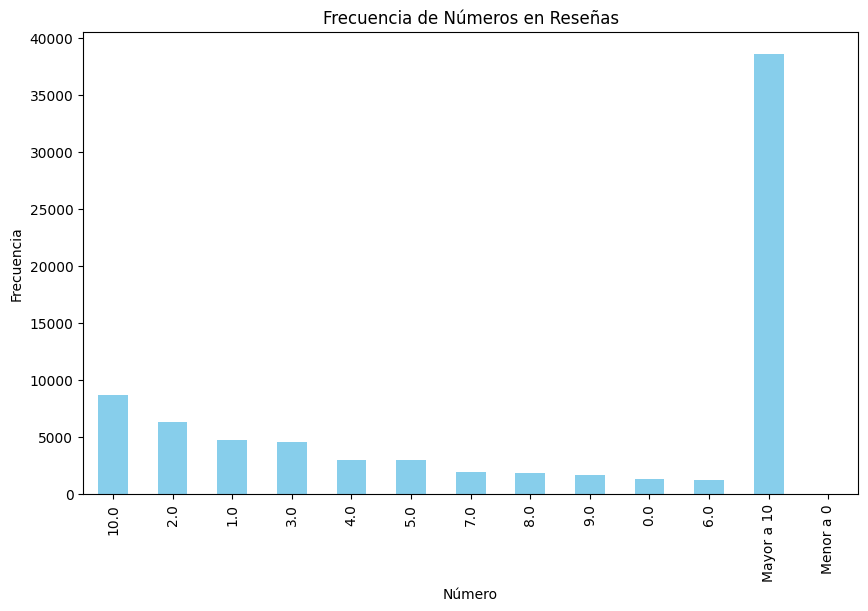

In [49]:
df['numeros_en_review'] = df['review_es'].str.extractall(r'(\d+)').astype(float).groupby(level=0)[0].apply(list)

todos_los_numeros = [numero for lista_numeros in df['numeros_en_review'].dropna() for numero in lista_numeros]

frecuencia_numeros = pd.Series(todos_los_numeros).value_counts()

frecuencia_filtrada = frecuencia_numeros[(frecuencia_numeros.index.astype(int) >= 0) & (frecuencia_numeros.index.astype(int) <= 10)]
mejores_valores = frecuencia_numeros[(frecuencia_numeros.index.astype(int) > 10)].sum()
peores_valores = frecuencia_numeros[(frecuencia_numeros.index.astype(int) < 0)].sum()
frecuencia_filtrada['Mayor a 10'] = mejores_valores
frecuencia_filtrada['Menor a 0'] = peores_valores

plt.figure(figsize=(10, 6))
frecuencia_filtrada.plot(kind='bar', color='skyblue')
plt.title('Frecuencia de Números en Reseñas')
plt.xlabel('Número')
plt.ylabel('Frecuencia')
plt.show()

Como se puede ver, hay una gran cantidad de reviews con numeros de nuestro interes, es por esto que vamos a indagar mas profundamente si nos provee informacion relevante.

/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/juampi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

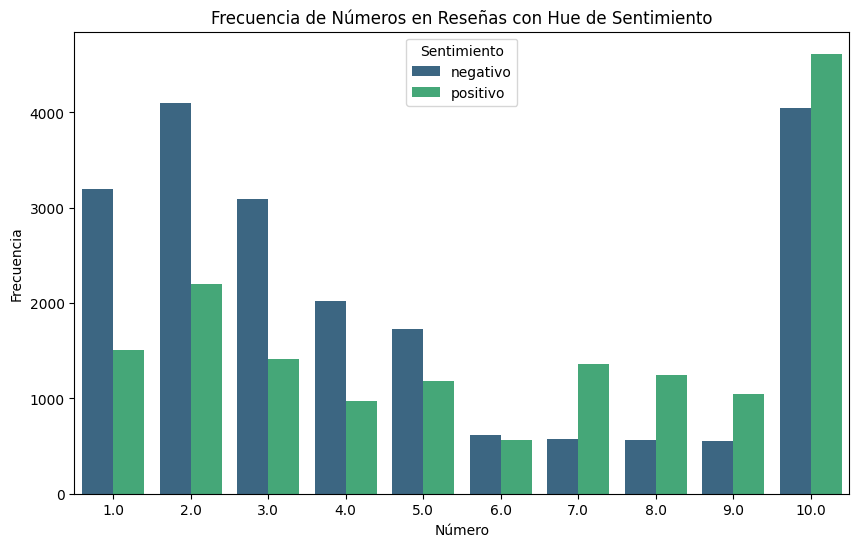

In [48]:
def extraer_numeros_y_sentimiento(texto, sentimiento):
    numeros = re.findall(r'(\d+)', texto)
    return [(int(numero), sentimiento) for numero in numeros]

df_numeros_sentimientos = df.apply(lambda row: extraer_numeros_y_sentimiento(row['review_es'], row['sentimiento']), axis=1).explode()

df_numeros_sentimientos = pd.DataFrame(list(df_numeros_sentimientos), columns=['numero', 'sentimiento'])

frecuencia_filtrada = df_numeros_sentimientos[(df_numeros_sentimientos['numero'] >= 1) & (df_numeros_sentimientos['numero'] <= 10)]
otros_valores = df_numeros_sentimientos[(df_numeros_sentimientos['numero'] < 1) | (df_numeros_sentimientos['numero'] > 10)].groupby('sentimiento').size().reset_index(name='count')
frecuencia_filtrada = frecuencia_filtrada.groupby(['numero', 'sentimiento']).size().reset_index(name='count')
frecuencia_filtrada = pd.concat([frecuencia_filtrada, otros_valores], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.barplot(x='numero', y='count', hue='sentimiento', data=frecuencia_filtrada, palette='viridis')
plt.title('Frecuencia de Números en Reseñas con Hue de Sentimiento')
plt.xlabel('Número')
plt.ylabel('Frecuencia')
plt.legend(title='Sentimiento')
plt.show()

Podemos ver que como se esperaba, en la mayoria de los numeros tiene un sentimiento acorde a su valor, exceptuando 10 que tiene un sentimiento muy parejo. Esto realmente nos sorprendio.

Por ultimo, vamos a verificar la cantidad total de palabras unicas en nuestro dataset antes del pre procesamiento.

In [329]:
tokens = []
for review in df['review_es']:
    tokens.extend(review.split())

palabras_unicas = set(tokens)
numero_de_palabras_unicas = len(palabras_unicas)

print("Numero de palabras unicas en el dataset pre preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset pre preprocesamiento: 559112


## Preprocesamiento

Comenzamos eliminando los duplicados identificados anteriormente ya que no nos aportan informacion adicional.

In [47]:
df = df.drop_duplicates(subset=['review_es'])
df.shape

(49599, 8)

Antes de borrar las reviews que esten en otro idioma, veremos si el idioma nos brinda alguna informacion en el sentimiento.

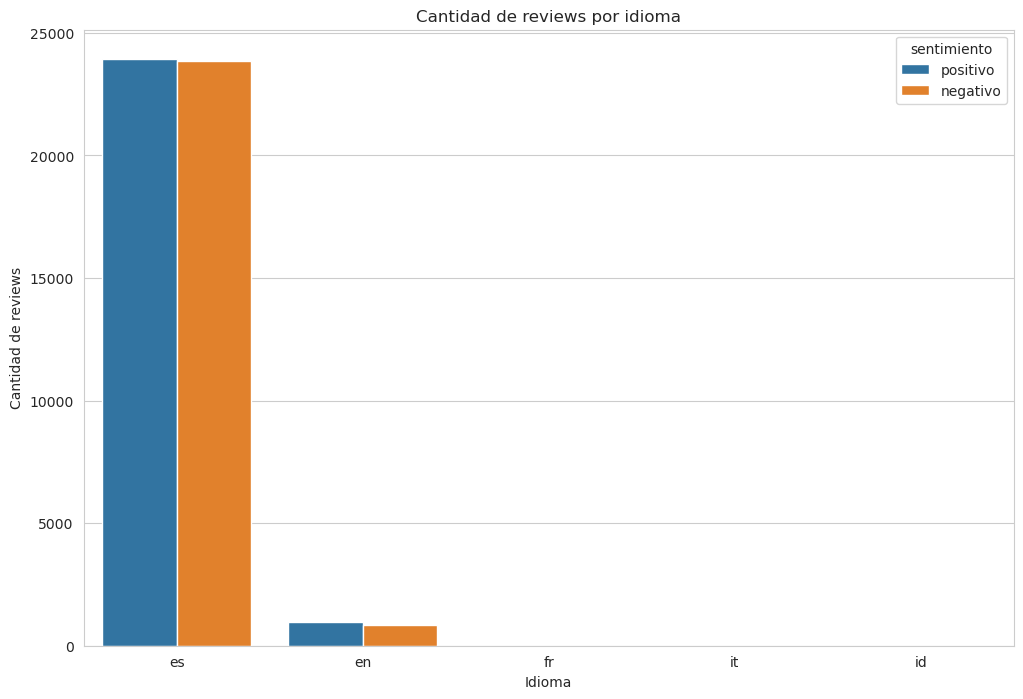

In [48]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.countplot(x='idioma', hue='sentimiento', data=df)
plt.xlabel('Idioma')
plt.ylabel('Cantidad de reviews')
plt.title('Cantidad de reviews por idioma')

plt.show()

Como la distribucion de sentimientos es bastante pareja, y teniendo en cuenta que con la traduccion nuestros modelos empeoraban su performance, elegimos eliminar las reviews que no esten en castellano.

In [49]:
df = df[df['idioma'].isin(['es'])]
df['idioma'].value_counts()

idioma
es    47782
Name: count, dtype: int64

Como pudimos ver anteriormente, existen unas reviews las cuales contienen emojis pero a pesar de que sean muy pocos igualmente vamos a convertirlos a texto.

In [245]:
df['review_es'] = df['review_es'].apply(demojize)

In [ ]:
df['tiene_emoji'] = df['review_es'].apply(emoji_count)
cantidad_emojis = df['tiene_emoji'].value_counts().reset_index()
cantidad_emojis.columns = ['cantidad_emojis', 'cantidad_filas']
cantidad_emojis

/var/folders/pm/lyty8ft16l3dvy_kdh07l4dc0000gn/T/ipykernel_79381/3651782182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tiene_emoji'] = df['review_es'].apply(emoji_count)


,cantidad_emojis,cantidad_filas
0,0,47783


Teniendo los emojis convertidos a texto podemos continuar trabajando con el dataset

A continuacion, vamos a eliminar todas las reviews que tengan el z-score mayor a 3 en modulo. Decidimos tener en cuenta este metodo ya que luego de utilizar ambos, sorprendentemente el z-score nos dio mejores resultados. Quizas se deba a que el z-score modificado es mas agresivo a la hora de eliminar outliers, dejandonos con bastante menos data para entrenar los modelos.

In [50]:
# df = df[np.absolute(df['zm_cantidad_de_palabras'] <= 3.5)]
# df.shape
df = df[np.absolute(df['zscore'] < 3)]
df.shape

(47120, 8)

Con esto, eliminamos casi un 5% de samples del dataset original, entre los duplicados, las reviews que no estaban en castellano y las que tenian un z-score mayor a 3 en modulo.

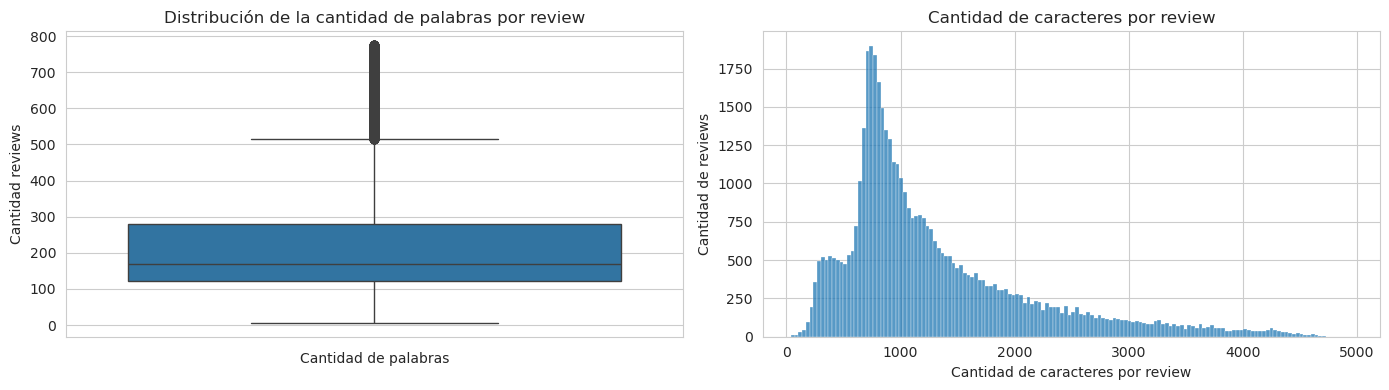

In [51]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.boxplot(df['cantidad_de_palabras'], fill=True, ax=ax1).set_title('Distribución de la cantidad de palabras por review')
ax1.set_ylabel('Cantidad reviews')
ax1.set_xlabel('Cantidad de palabras')

sns.histplot(df['longitud_review'],  ax=ax2, bins=150, kde=False).set_title('Cantidad de caracteres por review')
ax2.set_xlabel('Cantidad de caracteres por review')
ax2.set_ylabel('Cantidad de reviews')

plt.tight_layout()
plt.show()

In [52]:
df['longitud_review'].describe()

count    47120.000000
mean      1303.951677
std        843.374861
min         39.000000
25%        744.000000
50%       1020.000000
75%       1638.000000
max       4958.000000
Name: longitud_review, dtype: float64

Ademas, eliminando los samples que indicaba el z-score seguimos aptos para traducir las reviews ya que no superamos el limite de caracteres por request de la API de Google Translate.

/tmp/ipykernel_783/3171170284.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')


Text(0.5, 1.0, 'Cantidad de palabras por review')

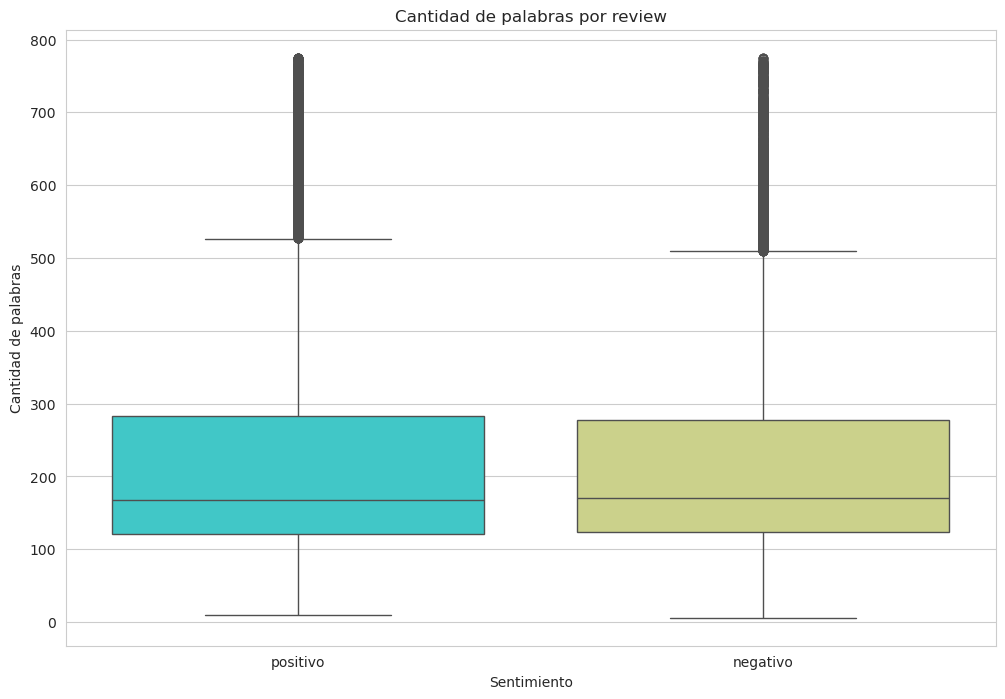

In [27]:
sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
sns.boxplot(x='sentimiento', y='cantidad_de_palabras', data=df, palette='rainbow')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de palabras')
plt.title('Cantidad de palabras por review')

Ademas, vamos a analizar que luego de la eliminacion de estos reviews nos quede una distribucion parecida de samples positivos y negativos.

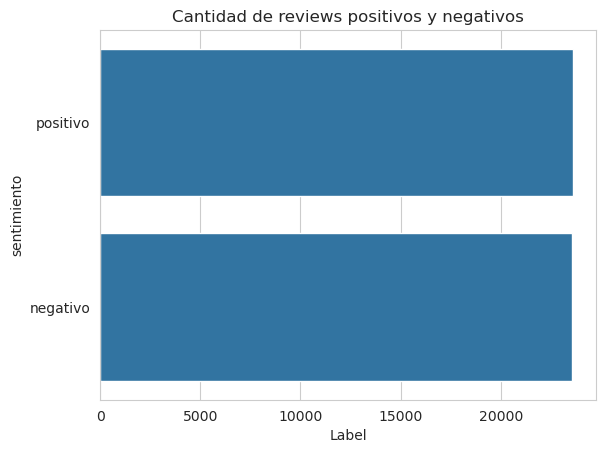

In [53]:
sns.countplot(df['sentimiento'])
plt.xlabel('Label')
plt.title('Cantidad de reviews positivos y negativos')
plt.show()

La cantidad sigue siendo bastante pareja, por lo tanto, podemos continuar con el preprocesamiento.

Como habiamos mencionado anteriormente, vamos a traducir las reviews que no esten en castellano. Para ello, vamos a utilizar la API de Google Translate. 

In [248]:
from deep_translator import GoogleTranslator

def traducir_al_castellano(texto, idioma):
    traduccion = GoogleTranslator(source='english', target='spanish').translate(texto)
    return traduccion

if not os.path.isfile('datasets/train_con_traduccion.csv'):
    for index, row in df.iterrows():
        if row['idioma'] == 'en':
            df.loc[index, 'review_es'] = traducir_al_castellano(row['review_es'],'en' )
    df.to_csv('datasets/train_con_traduccion.csv', index=False)
else:
    df = pd.read_csv('datasets/train_con_traduccion..csv', sep=',')

NotValidLength: From the film's first shot - Keira Knightley as Elizabeth Bennet wandering reading through a field at dawn, thus invoking all the clichés cinema has developed to address the phenomenon of the strong-minded rebellious female character in period drama - I knew I was in for something to make me want to kill myselfJoe Wright seemed not only to have not read the book, but to be under the regrettable misapprehension that what he was filming was not in fact Jane Austen's subtle, nuanced comedy of manners conducted through sparkling, delicate social interaction in eighteenth century English drawing-rooms, but a sort of U-certificate Wuthering Heights Thus we were treated to every scene between Elizabeth and Darcy taking place outside for no apparent reason, in inappropriately rugged scenery and often in the pouring rain Not to mention that Jane Austen, and in particular P & P, is not about passion, sexual tension or love It's about different strategies of negotiating the stultification of eighteenth century society Which was completely ignored, so that the Bennets' house was a rambunctious, chaotic place where everybody shouts at once, runs around, leaves their underwear on chairs, and pigs wander happily through the house; the society balls become rowdy country dances one step away from a Matrix Reloaded style dance-orgy; and everybody says exactly what they think without the slightest regard for proprietyThe genius of Jane Austen lies in exploring the void created by a society in which nobody says what they think or mean because of an overwhelming regard for propriety, and the tragic predicaments of her characters arise from misunderstandings and miscommunications enabled by that speechless gap So both the brilliance of Jane Austen and the very factor that allows her plots - particularly in this film - to function was completely erased Subtlety in general was nowhere int his film, sacrificed in favour of an overwrought drama which jarred entirely with the material and the performancesIt was so obviously trying to be a *serious* film The humour - which IS Pride & Prejudice, both Austen's methodology and her appeal - was almost entirely suppressed in favour of all this po-faced melodrama, and when it was allowed in, was handled so clumsily Pride & Prejudice is a serious narrative which makes serious points, yes, but those serious points and weightier themes are not just intertwined with the humour, they are embedded in it You can't lose Jane Austen's technique, leaving only the bare bones of the story, and expect the themes to remain Not even when you replace her techniques with your own heavy-handed mystical-numinous fauxbrow cinematographyElizabeth Bennett is supposed to be a woman, an adult, mature and sensible and clear-sighted Keira Knightley played the first half of the film like an empty-headed giggling schoolgirl, and the second half like an empty-headed schoolgirl who thinks she is a tragic heroine Elizabeth's wit, her combative verbal exchanges, her quintessential characteristic of being able to see and laugh at everybody's follies including her own, her strength and composure, and her fantastic clear-sightedness were completely lost and replaced with  what? A lot of giggling and staring into the distance? Rather than being able to keep her head when all about her were losing theirs, she started to cry and scream at the slightest provocation - and not genuinely raging, either; no, these were petulant hissy fits And where the great strength of Austen's Elizabeth (at least in Austen's eyes) was her ability to retain integrity and observance while remaining within the boundaries of society and sustaining impeachable propriety, Knightley's Elizabeth had no regard whatsoever for convention Furthermore, she seemed to think that wandering around barefoot in the mud in the eighteenth century version of overalls established her beyond doubt as spirited and strong-minded, and therefore nothing in the character as written or the performance had to sustain it An astonishingly unsubtle and bland performance In which quest for blandness and weakness, she was ably matched by Matthew MacfaydenDonald Sutherland as Mr Bennet seemed weak, ineffectual and permanently befuddled without the wicked sense of humour and ironic detachment at the expense of human relationships that makes Mr Bennet so fascinating and tragic His special bond with Lizzie, as the only two sensible people in a world of fools, was completely lost, not least because both of them were fools in a world of fools, and that completely deprived the end of the film of emotional impact Mr Bingley was no longer amiable and well-meaning to the point of folly, but was played as a complete retard for cheap laughs, and the woman who was playing Jane was so wildly inconsistent that she may as well not have tried to do anything with the character at all The script veered wildly between verbatim chunks of Jane Austen - delivered with remarkable clumsiness - and totally contemporaneous language which would not be out of place in a modern day romantic comedyJust get the BBC adaptation on DVD and save yourself the heartache --> Text length need to be between 0 and 5000 characters

A continuacion realizaremos un paso muy importante en este tp, el cual va a reducir el tiempo de entrenaminto de los modelos, va a mejorar su performance y va a evitar que los modelos se sobreajusten. Este paso es el preprocesamiento de las reviews.

Los pasos a realizar son los siguientes:

- limpiar texto = Elimina los caracteres que no sean un caracter alfanumerico y los reemplaza por espacios en blanco. Elimina las palabras que tienen solo un carácter alfabético y las reemplaza por espacios en blanco. Sustituye múltiples espacios en blanco por uno solo. Convierte todos los caracteres del texto a minúsculas.

- filtrar stopwords = elimina las stopwords que son palabras comunes sin significado específico.

- stem palabras = reduce cada token a su raíz (o "stem").

- tokenize = realiza una serie de operaciones de preprocesamiento y devuelve el texto tokenizado y procesado.

In [17]:
df_preprocesado = df.copy()

tokenizer = ToktokTokenizer() 
STOPWORDS = set(stopwords.words("spanish"))
stemmer = nltk.stem.SnowballStemmer("spanish")

def limpiar_texto(texto):
    # Eliminamos los caracteres especiales
    texto = re.sub(r'\W', ' ', str(texto))
    # Eliminado las palabras que tengo un solo caracter
    texto = re.sub(r'\s+[a-zA-Z]\s+', ' ', texto)
    # Sustituir los espacios en blanco en uno solo
    texto = re.sub(r'\s+', ' ', texto, flags=re.I)
    # Convertimos textos a minusculas
    texto = texto.lower()
    return texto

def filtrar_stopword_digitos(tokens):
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]

def stem_palabras(tokens):
    return [stemmer.stem(token) for token in tokens]

def tokenize(texto):
    text_cleaned = limpiar_texto(texto)
    tokens = [word for word in tokenizer.tokenize(text_cleaned) if len(word) > 1]
    tokens = filtrar_stopword_digitos(tokens)
    stems = stem_palabras(tokens)
    stems = ' '.join(stems)
    return stems

In [34]:
df_preprocesado['review_es'] = df_preprocesado['review_es'].apply(tokenize)

In [4]:
nombre_df_exportar = 'datasets/train_preprocesado_sin_traduccion_z_score.csv'
if not os.path.isfile(nombre_df_exportar):
    df_preprocesado.to_csv(nombre_df_exportar, index=False)

Utilizameros el dataset ya preprocesado sin traducciones, o sea, que elimina las reviews que no estaban en castellano. Ademas, elimina los outliers marcados por el z-score. Esto lo hicimos para ahorrarnos tiempo de ejecucion ya que tenemos frecuentemente crasheos del kernel.

In [5]:
nombre_df = 'datasets/train_preprocesado_sin_traduccion_z_score.csv'
df_preprocesado = pd.read_csv(nombre_df, sep=',')

Con esto podemos observar brevemente como quedan las reviews luego de este preprocesamiento.

In [30]:
df_preprocesado.head(10)

,ID,review_es,sentimiento,cantidad_de_palabras,zscore,zm_cantidad_de_palabras,longitud_review,idioma
0,0,critic mencion despues ver sol oz episodi enga...,positivo,345,0.600271,1.823258,2004,es
1,1,pequeñ pequeñ produccion tecnic filmacion incu...,positivo,161,-0.424631,-0.115930,1061,es
2,2,pens maner maravill pas tiemp fin seman veran ...,positivo,173,-0.357789,0.010539,989,es
3,3,basic famili niñ pequeñ jak piens zombi armari...,negativo,137,-0.558314,-0.368867,790,es
4,4,amor tiemp pett mattei pelicul visual impresio...,positivo,237,-0.001302,0.685039,1406,es
5,5,probabl pelicul favorit tiemp histori desinter...,positivo,123,-0.636295,-0.516414,724,es
6,6,segur gust ver resurreccion seri seahunt dat t...,positivo,157,-0.446911,-0.158086,839,es
7,7,espectacul ide increibl fresc innov años emit ...,negativo,168,-0.385640,-0.042156,1034,es
8,8,alent comentari posit pelicul aqu des ver peli...,negativo,120,-0.653006,-0.548031,708,es
9,9,si gust ris original desgarr gust pelicul si j...,positivo,31,-1.148747,-1.486008,186,es


In [331]:
tokens = []
for review in df_preprocesado['review_es']:
    tokens.extend(review.split())

palabras_unicas = set(tokens)
numero_de_palabras_unicas = len(palabras_unicas)

print("Numero de palabras unicas en el dataset post preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset post preprocesamiento: 86376


Se puede observar que el preprocesamiento disminuyo notablemente nuestro bag of words.

Como ultimo paso del preprocesamiento, dividimos el dataset en train y test. Utilizamos un ratio de 80% para train y 20% para test. Ademas, utilizamos el parametro random_state para que la division sea reproducible. Tambien trasladamos los labels a valores numericos para poder trabajar con ellos.

In [6]:
df_preprocesado['sentimiento'] = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

x_train, x_test, y_train, y_test = train_test_split(df_preprocesado['review_es'], df_preprocesado['sentimiento'], test_size=0.2, random_state=42)

## Entrenamiento de modelos

Cabe recalcar que para cada modelo utilizamos CounVectorizer y TfidfVectorizer para ver cual nos brindaba mejores resultados. Solo mantenemos el que mejor performance nos brindo. Ademas, utilizamos RandomizedSearchCV para encontrar los mejores hiperparametros para los modelos principales.

### Modelos de Bayes Naïve

#### Bayes Naïve Multinomial

##### Vamos a probar en primer lugar con un count vectorizer y luego con un tfidf vectorizer par ver con cual obtenemos merjores resultados

In [20]:
modelo_count = make_pipeline(CountVectorizer(), MultinomialNB())
modelo_tfidf = Pipeline([('tvec', TfidfVectorizer()), ('mnb',MultinomialNB())])

In [25]:
modelo_count.fit(x_train, y_train)
prediccion_count = modelo_count.predict(x_test)

mostrar_scores(y_test, prediccion_count)

Accuracy: 0.8492468003171367
Recall: 0.8321550741163056
Precision: 0.8598020735155514
f1 score: 0.845752694402596


In [40]:
modelo_tfidf.fit(x_train, y_train)
prediccion_tfidf = modelo_tfidf.predict(x_test)

mostrar_scores(y_test, prediccion_tfidf)

Accuracy: 0.8436969079170914
Recall: 0.8120866590649943
Precision: 0.8649502064610153
f1 score: 0.8376852505292872


En este caso, dio mejores resultados el count vectorizer. Sin embargo, por investigaciones nuestras, creemos que el tfidf es superior para este tipo de problemas. De todas maneras, por cada modelo vamos a probar los dos quedandonos con el mejor, tal como dijimos anteriormente.

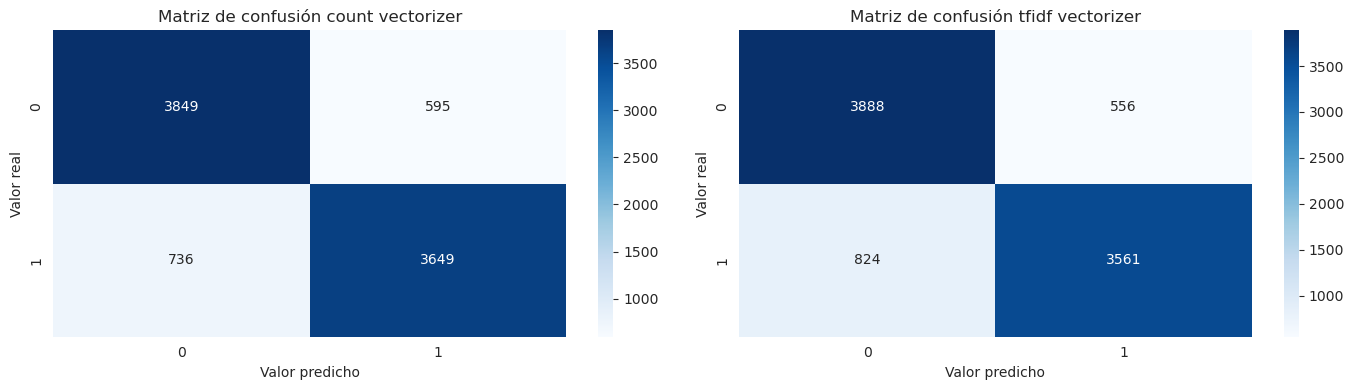

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

matriz_confusion = confusion_matrix(y_test, prediccion_count)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', ax=ax1).set_title('Matriz de confusión count vectorizer')
ax1.set_xlabel('Valor predicho')
ax1.set_ylabel('Valor real')

matriz_confusion = confusion_matrix(y_test, prediccion_tfidf)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', ax=ax2).set_title('Matriz de confusión tfidf vectorizer')
ax2.set_xlabel('Valor predicho')
ax2.set_ylabel('Valor real')

plt.tight_layout()
plt.show()

Podemos ver que en que en ambos casos nuestro modelo tiende a predecir a una review como negativa. Es por esto que la metrica de recall se ve tan baja comparada a la precision.

In [42]:
prediccion_count_train = modelo_count.predict(x_train)
prediccion_tfidf_train = modelo_tfidf.predict(x_train)

print("Prediccion en train con count vectorizer")
mostrar_scores(y_train, prediccion_count_train)
print("----------------------------------------")
print("Prediccion en train con tfidf vectorizer")
mostrar_scores(y_train, prediccion_tfidf_train)

Prediccion en train con count vectorizer
Accuracy: 0.9045960411180018
Recall: 0.8874715261958998
Precision: 0.9179478117453025
f1 score: 0.9024524423082492
----------------------------------------
Prediccion en train con tfidf vectorizer
Accuracy: 0.8978846317220287
Recall: 0.8745444191343964
Precision: 0.9162887828162292
f1 score: 0.8949300699300698


Notamos que en ambos casos, nuestro modelo esta overfitteado.

Vamos a resolver este limitando la cantidad de features que utiliza el modelo. Para ello, vamos a utilizar el parametro max_features del vectorizer. De ahora en mas continuaremos solo con el count vectorizer ya que obtuvimos mejores resultados con el.

In [43]:
vectorizer = CountVectorizer(max_features=6000)
modelo_tfidf = make_pipeline(vectorizer, MultinomialNB(alpha=0.1))
modelo_tfidf.fit(x_train, y_train)

prediccion = modelo_tfidf.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8432438554762713
Recall: 0.8389965792474344
Precision: 0.8443883406013312
f1 score: 0.8416838252116221


In [44]:
prediccion_train = modelo_tfidf.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.858550675388667
Recall: 0.8559794988610478
Precision: 0.8590615534091559
f1 score: 0.857517756796075


Con esto, podemos ver que nuestro modelo mantuvo su performance. Ademas, podemos ver que ya no esta overfitteado.

#### Bayes Naive Multinomial con bigramas

Este modelo tienen en cuenta la cantidad de apariciones de cada palabra y de cada par de palabras. 

Ahora vamos a probar una variante interesante la cual consiste en usar unigramas y bigramas. Para ello, vamos a utilizar el parametro ngram_range del vectorizer. 

In [308]:
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=5, max_df=0.7, norm='l1')
modelo_bigramas = make_pipeline(vectorizer, MultinomialNB(alpha=0.5))
modelo_bigramas.fit(x_train, y_train)

prediccion = modelo_bigramas.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8724533106960951
Recall: 0.8952299829642248
Precision: 0.8555148555148555
f1 score: 0.8749219562955254


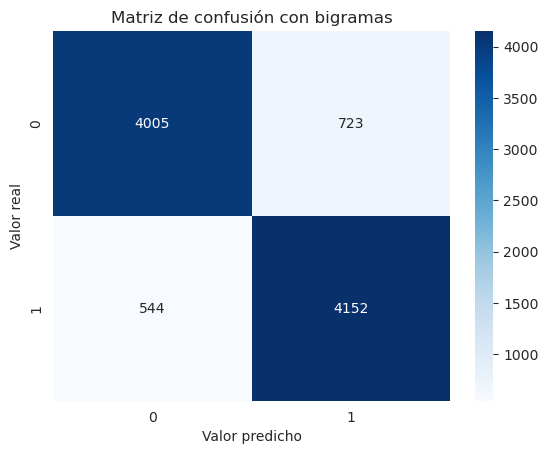

In [51]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión BN multinomial con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [301]:
prediccion_train = modelo_bigramas.predict(x_train)

mostrar_scores(y_train, prediccion_train)


Accuracy: 0.8925084889643463
Recall: 0.9202181163640214
Precision: 0.8722838360014051
f1 score: 0.8956100577081615


Notamos una gran mejoria en la metrica de recall, lo cual es muy bueno ya que nuestro modelo ahora esta prediciendo mejor las reviews negativas. Sin embargo, la metrica de precision disminuyo un poco. El lado positivo es que nuestro modelo sigue sin estar overfitteado.

#### Bayes Naive Gausseano

In [5]:
vectorizer = TfidfVectorizer(max_features=2000)
modelo_gauss = make_pipeline(vectorizer, DenseTransformer(), GaussianNB())
modelo_gauss.fit(x_train, y_train)

prediccion = modelo_gauss.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.7875184052554083
Recall: 0.7863169897377423
Precision: 0.7859585137907454
f1 score: 0.786137710898313


In [6]:
prediccion_train = modelo_gauss.predict(x_train)

mostrar_scores(y_train, prediccion_train)

: 

Notamos que los resultados de este tipo de modelo son muy pobres comparado a los anteriores. Es por ello que no vamos probarlo en profundidad.

#### Bayes Naive Bernoulli

Este modelo a diferencia del multinomial, solo tiene en cuenta si una palabra ocurre o no.

Aca decidimos experimentar mas en profundidad los parametros del vectorizer. Nos vamos a quedar con los que mejor resultados nos dieron.

In [321]:
vectorizer = TfidfVectorizer(max_features=25000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_bernoulli = make_pipeline(vectorizer, BernoulliNB( alpha=0.5
))
modelo_bernoulli.fit(x_train, y_train)

prediccion = modelo_bernoulli.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.868739388794567
Recall: 0.8916098807495741
Precision: 0.851881993896236
f1 score: 0.8712933097492457


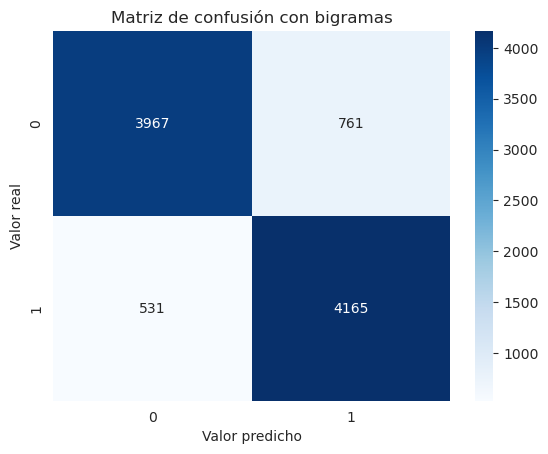

In [40]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión BN bernoulli con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

In [318]:
prediccion_train = modelo_bernoulli.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8898026315789473
Recall: 0.9087299486473609
Precision: 0.8759887726460832
f1 score: 0.8920590375220872


Aqui podemos observar otro gran modelo a tener en cuenta ya que obtuvimos muy buenos resultados. El aspecto positivo de estos modelos de Bayes Naive es que son muy rapidos de entrenar y de predecir.

#### Busqueda de hiperparametros

In [ ]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_multinomial_BN = MultinomialNB()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_iter = 25
param_grid = {'alpha': [0.1, 1.5, 2.0],
                'fit_prior': [True, False]}
random_search = RandomizedSearchCV(modelo_multinomial_BN, param_grid, n_iter=n_iter, cv=cv, scoring='f1', n_jobs=-1, verbose=3, random_state=42)
random_search.fit(X, y)

In [ ]:
print("Mejor estimador: ")
print(random_search.best_estimator_)
print("Mejor score: ")
print(random_search.best_score_)
print("Mejores parametros: ")
print(random_search.best_params_)

#### Busqueda de hiperparametros de TFIDF

Observamos tanto en local como en lo sresultados de kaggle que los prametros del tfidf vectorizer afectan mucho a la performance de los modelos. Es por ello que vamos a realizar una busqueda de hiperparametros para el tfidf vectorizer.

In [268]:
vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2))
modelo_multinomial_BN_random = BernoulliNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

n_iter = 25
pipe = Pipeline([('vectorizer', vectorizer), ('modelo', modelo_multinomial_BN_random)])

param_grid = {'vectorizer__max_features': [10000, 20000, 30000, 50000],
              'vectorizer__min_df': [5, 10, 15],
              'vectorizer__max_df': [0.7, 0.8, 0.9],
              'modelo__alpha': list(np.linspace(0.1, 1, num=10)),
              'modelo__fit_prior': [True, False]}

random_search = RandomizedSearchCV(pipe, param_grid, n_iter=n_iter, cv=cv, scoring='f1', n_jobs=-1, verbose=3, random_state=42)

random_search.fit(x_train, y_train)

print("Mejor estimador: ")
print(random_search.best_estimator_)
print("Mejor score: ")
print(random_search.best_score_)

print("Mejores parametros: ")
print(random_search.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 4/5] END modelo__alpha=0.5, modelo__fit_prior=False, vectorizer__max_df=0.8, vectorizer__max_features=20000, vectorizer__min_df=10;, score=0.869 total time= 3.1min
[CV 1/5] END modelo__alpha=0.5, modelo__fit_prior=True, vectorizer__max_df=0.7, vectorizer__max_features=10000, vectorizer__min_df=15;, score=0.866 total time= 3.1min
[CV 1/5] END modelo__alpha=0.5, modelo__fit_prior=False, vectorizer__max_df=0.8, vectorizer__max_features=20000, vectorizer__min_df=10;, score=0.866 total time= 3.1min
[CV 2/5] END modelo__alpha=0.5, modelo__fit_prior=True, vectorizer__max_df=0.7, vectorizer__max_features=10000, vectorizer__min_df=15;, score=0.868 total time= 3.1min
[CV 3/5] END modelo__alpha=0.5, modelo__fit_prior=True, vectorizer__max_df=0.7, vectorizer__max_features=10000, vectorizer__min_df=15;, score=0.859 total time= 3.1min
[CV 2/5] END modelo__alpha=0.5, modelo__fit_prior=False, vectorizer__max_df=0.8, vectorizer__max_feat

#### Predicción en los datos de test para kaggle

In [320]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_procesado = df_test.copy()

df_test_procesado['review_es'] = df_test_procesado['review_es'].apply(demojize)
df_test_procesado['review_es'] = df_test_procesado['review_es'].apply(tokenize)

prediccion = modelo_bernoulli.predict(df_test_procesado['review_es'])

prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()


df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('bernoulliNB_l1.csv', index=False)

### Regresión Logística

Realizaremos una regresion logistica ya que si bien el enunciado no lo pide, leimos que tiene una performance muy buena para este tipo de problemas.

In [282]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_regresion_logistica = Pipeline([('tfidf', vectorizer), ('lr', LogisticRegression(
    penalty='l2',
    C=0.3,
    solver='liblinear',
    max_iter=100, 
    l1_ratio=None, 
    tol=1e-4,
))])
modelo_regresion_logistica.fit(x_train, y_train)

prediccion = modelo_regresion_logistica.predict(x_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8850806451612904
Recall: 0.8973594548551959
Precision: 0.8751817237798546
f1 score: 0.8861318473346651


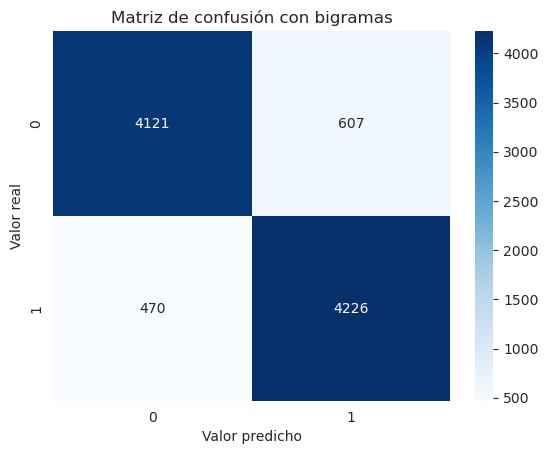

In [66]:
matriz_confusion = confusion_matrix(y_test, prediccion)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues').set_title('Matriz de confusión regresion logistica con bigramas')
plt.xlabel('Valor predicho')
plt.ylabel('Valor real')
plt.show()

Se puede observar en este heatmap que nuestro modelo tiene tendencia a predecir a las reviews como positivas. 

In [67]:
prediccion_train = modelo_regresion_logistica.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9059581918505942
Recall: 0.920694584149505
Precision: 0.8946908118119148
f1 score: 0.9075064575886451


#### Busqueda de hiperparametros

In [31]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_regresion_logistica = LogisticRegression()

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l2']
space['C'] = [0.01, 0.1, 0.3, 0.5, 1.0, 3]
space['l1_ratio'] = [None]
space['max_iter'] = [50, 100, 200, 300]

n_iter = 100
search = RandomizedSearchCV(modelo_regresion_logistica, space, n_iter=5, scoring='f1', n_jobs=-1, cv=cv, random_state=42)
result = search.fit(X, y)

Con esto vemos los resultados de nuestra busqueda de hiperparametros.

In [32]:
print('Mejor Score: %s' % result.best_score_)
print('Mejores hiperparametros: %s' % result.best_params_)

promedios = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for promedio, param in zip(promedios, params):
    print(">%.3f with: %r" % (promedio, param))

Mejor Score: 0.8839520777881859
Mejores hiperparametros: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 3}
>0.847 with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': None, 'C': 0.01}
>0.884 with: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 3}
>0.867 with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 200, 'l1_ratio': None, 'C': 0.1}
>0.847 with: {'solver': 'newton-cg', 'penalty': 'l2', 'max_iter': 50, 'l1_ratio': None, 'C': 0.01}
>0.876 with: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 100, 'l1_ratio': None, 'C': 0.3}


Luego de la busqueda de hiperparametros, podemos ver que nuestro modelo no mejoro su performance, ademas que detecto como mejor modelo uno con C = 3, el cual tiende a realizar overfitting.

#### Predicción en los datos de test para kaggle

In [58]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

#df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_regresion_logistica.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_upgrade.csv', index=False)

### XGBoost

Seguiremos con un modelo de XGBoost ya que es un modelo que esperamos que va a tener muy buenos resultados.

In [11]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_xg_boost = Pipeline([
  ('tfidf', vectorizer), 
  ('xgb', XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        colsample_bytree=0.6, 
        subsample=0.6,
        gamma=0.3, 
        max_depth=5,
        learning_rate=0.089, 
        min_child_weight=10, 
        n_estimators=700, 
))])

modelo_xg_boost.fit(x_train, y_train)

y_pred = modelo_xg_boost.predict(x_test)

mostrar_scores(y_test, y_pred)

KeyboardInterrupt: 

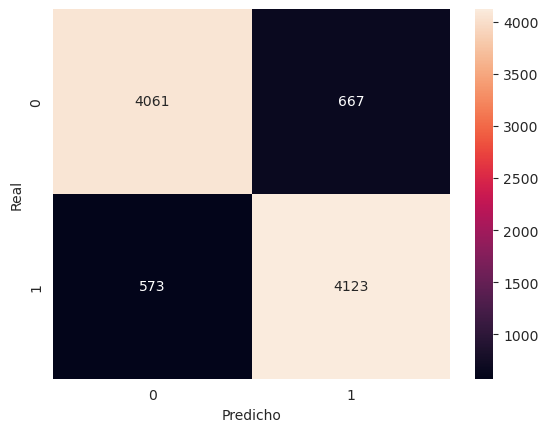

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión XGBoost')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

A continuacion, vamos a analizar que tan overfitteado esta nuestro modelo ya que en el tp1 notamos que este modelo tiende a overfittearse facilmente. 

In [70]:
y_pred_train = modelo_xg_boost.predict(x_train)

mostrar_scores(y_train, y_pred_train)

Accuracy: 0.9218219439728353
Recall: 0.9347768542537985
Precision: 0.9114701631220318
f1 score: 0.9229763989440946


Ademas de ser un poco mas costoso para entrenar comparado a los mdoelos anteriores, brinda peores resultados y se puede ver que esta levemente overfitteado.

#### Busqueda de hiperparametros

In [40]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_xg_boost = XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,  0.3,  0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': list(np.linspace(0.001, 0.1, 10)),
        'n_estimators': [ 300, 400, 500, 600, 700, 800, 900, 1000],
        }

folds = 5
n_iter = 100
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(modelo_xg_boost, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=cv, random_state=42 )
random_search.fit(X, y)

/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/mateov/programas/anaconda3/lib/python3.11/site-pac

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importan...
                   n_iter=1, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.1, 0.3, 0.5],
                                        'learning_rate': [0.001, 0.012,
                                                          0.023000000000000003,
                                                          0.034,
                                                          0.045000000000000005,
                                                          0.05600000000000001,
                                                          0.067,
                                                          0.07800000000000001,
                                                          0.08900000000000001,
                                                          0.1],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [300, 400, 500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1')

In [41]:
print('\n Mejor estimador:')
print(random_search.best_estimator_)
print('\n Mejor hiperparm:')
print(random_search.best_score_)


 Mejor estimador:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08900000000000001,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

 Mejor hiperparm:
0.8642347928007048


#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)


prediccion = modelo_xg_boost.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Random Forest

Otro modelo que utilizaremos es el de Random Forest ya que es un modelo que esperamos que va a tener buenos resultados. Sin embargo, creemos que no va a superar a XGBoost. La ventaja de este modelo es que es muy rapido de entrenar y de predecir.

In [19]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_random_forest = Pipeline([
    ('tfidf', vectorizer), 
    ('rfc', RandomForestClassifier(
            criterion='entropy',
            n_jobs=-1,
            random_state=42,
            max_depth=20,
            min_samples_leaf=50,
            n_estimators=900,
    ))])

modelo_random_forest.fit(x_train, y_train)

y_pred = modelo_random_forest.predict(x_test)

mostrar_scores(y_test, y_pred)

Accuracy: 0.8215195246179966
Recall: 0.8579642248722317
Precision: 0.798770816812054
f1 score: 0.8273100616016427


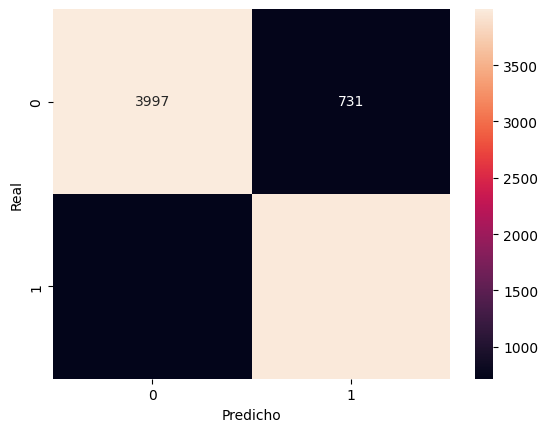

In [9]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión RandomForest')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [20]:
y_pred_train = modelo_random_forest.predict(x_train)

mostrar_scores(y_train, y_pred_train)

Accuracy: 0.8412828947368421
Recall: 0.8827889247710308
Precision: 0.8156427313637253
f1 score: 0.8478885414283172


#### Busqueda de hiperparametros

In [21]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
X = vectorizer.fit_transform(df_preprocesado['review_es'])
y = df_preprocesado['sentimiento'].map({'negativo': 0, 'positivo': 1, 0: 0, 1: 1})

modelo_random_forest = RandomForestClassifier(
    criterion='entropy',
    n_jobs=-1,
    random_state=42
)

params = {
        'n_estimators': [500, 750, 1000, 1250, 1500, 1750, 2000],
        'max_depth': [10, 20, 30, 40, 50, 60],
        'min_samples_leaf': [25, 50, 75, 100, 125, 150, 175, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample']
        }
    
folds = 5
n_iter = 5
cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(modelo_random_forest, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=cv, random_state=42 )
random_search.fit(X, y)

KeyboardInterrupt: 

In [44]:
print('\n Mejor estimador:')
print(random_search.best_estimator_)
print('\n Mejor hiperparm:')
print(random_search.best_score_ )


 Mejor estimador:
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_leaf=100,
                       n_estimators=1000, n_jobs=-1, random_state=42)

 Mejor hiperparm:
0.8403339887850227


#### Predicción en los datos de test para kaggle

In [18]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_random_forest.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('random_forest.csv', index=False)

### SVM

Tambien decidimos implementar este modelo porque, averiguando en internet, vimos que es un modelo que tiene muy buenos resultados para este tipo de problemas. El problema de este modelo es que solo se entrena en un hilo, por lo tanto, es muy lento de entrenar y para predecir

In [ ]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2))
modelo_svm = Pipeline([
    ('tfidf', vectorizer), 
    ('svm', SVC(C=1, probability=True, gamma='auto', kernel='rbf'))
    ])

modelo_svm.fit(x_train, y_train)

y_pred = modelo_svm.predict(x_test)

mostrar_scores(y_test, y_pred)

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión SVM')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
y_pred_train = modelo_svm.predict(x_train)

mostrar_scores(y_train, y_pred_train)    

Por lo mencionado al principio, decidimos no realizar una busqueda de hiperparametros ya que el tiempo de entrenamiento seria muy largo.

#### Predicción en los datos de test para kaggle

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = modelo_svm.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_preproceso_demoji.csv', index=False)

### Arbol de decision

In [12]:
vectorizer = TfidfVectorizer(max_features=7000, ngram_range=(1, 2), min_df=5, max_df=0.7, binary=True)
modelo_arbol = Pipeline([
    ('tfidf', vectorizer), 
    ('dtc', DecisionTreeClassifier(
            criterion='entropy',
            random_state=42,
            max_depth=120,
            min_samples_leaf=50,
    ))])

modelo_arbol.fit(x_train, y_train)

y_pred = modelo_arbol.predict(x_test)

mostrar_scores(y_test, y_pred)

Accuracy: 0.7522283531409168
Recall: 0.7659710391822828
Precision: 0.7442582247051521
f1 score: 0.7549585475915628


Con estos resultados podemos determianr que es un modelo muy pobre comparado con los que venimos utilizando. Sin embargo, es un modelo muy rapido de entrenar y de predecir. Decidimos utilizarlo ya que en el tp1 nos brindo grandes resultados, pero seguramente no es un modelo muy positivo para este tipo de problemas.

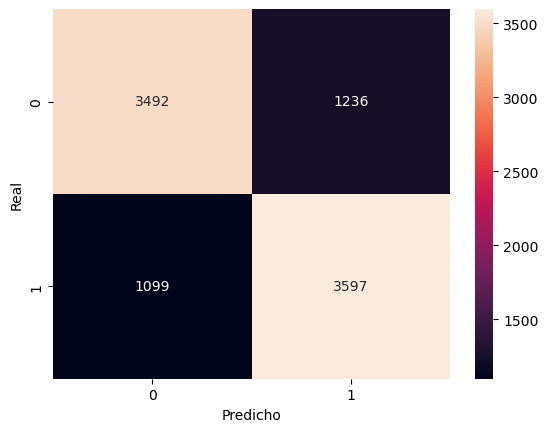

In [13]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión arbol de decision')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [15]:
y_pred_train = modelo_arbol.predict(x_train)

mostrar_scores(y_train, y_pred_train)

Accuracy: 0.7934794142614601
Recall: 0.8076128963947271
Precision: 0.7860970833762754
f1 score: 0.7967097532314923


### Red Neuronal

Vamos a intentar en primer lugar con una red neuronal simple con GRU para ver que resultados nos brinda. Luego, vamos a probar con una red neuronalmas compleja para ver si podemos mejorar los resultados.

In [51]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)


df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

max_words = 10000
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

def red_neuronal_recurrente():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 128, input_length=max_len)(inputs)
    layer = GRU(64)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = tf.keras.Model(inputs=inputs,outputs=layer)
    return model

model_rnn = red_neuronal_recurrente()
model_rnn.summary()
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_rnn.fit(sequences_matrix, y_train, batch_size=128, epochs=10, 
            validation_split=0.3,callbacks=[EarlyStopping(min_delta=0.0001)])

test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

accr = model_rnn.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

prediccion = model_rnn.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding_6 (Embedding)     (None, 1000, 128)         1280000   
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_3 (Activation)   (None, 1)                 0         
                                                                 
Total params: 1334145 (5.09 MB)
Trainable params: 1334145 (

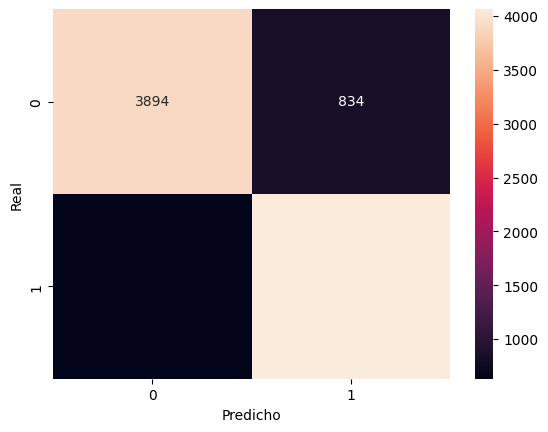

In [52]:
prediccion_heatmap = np.where(prediccion == 'positivo', 1, 0)

tabla = confusion_matrix(y_test, prediccion_heatmap)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [54]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model_rnn.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

1178/1178 [==============================] - 29s 25ms/step
Accuracy: 0.949411078098472
Recall: 0.9572237810365821
Precision: 0.9427007299270073
f1 score: 0.9499067482728729


Como podemos ver, los resultados no son malos pero vamos a intentar con una capa convolucional para ver si podemos mejorar los resultados.

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
x_train, x_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=sequences_matrix, y=y_train, epochs=10)

# model.evaluate(x=x_test, y=y_test)


Epoch 1/10


2023-11-15 22:15:33.883538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 22:15:33.884783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 22:15:33.885307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 553s 509ms/step - loss: 0.4476 - accuracy: 0.7848
Epoch 2/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.2515 - accuracy: 0.8988
Epoch 3/10
1085/1085 [==============================] - 531s 489ms/step - loss: 0.1804 - accuracy: 0.9318
Epoch 4/10
1085/1085 [==============================] - 533s 491ms/step - loss: 0.1094 - accuracy: 0.9612
Epoch 5/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0599 - accuracy: 0.9803
Epoch 6/10
1085/1085 [==============================] - 553s 509ms/step - loss: 0.0414 - accuracy: 0.9860
Epoch 7/10
1085/1085 [==============================] - 540s 498ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 8/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0200 - accuracy: 0.9933
Epoch 9/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.0201 - accuracy: 0.9929
Epoch 10/10
1085/1085 [==============================] - 

In [ ]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=1000)
prediccion = model.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8436155913978495
Recall: 0.8690796555435952
Precision: 0.8266990912581594
f1 score: 0.8473597900951131


In [ ]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

2023-11-15 23:53:15.747490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 23:53:15.748132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 23:53:15.748825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 126s 115ms/step
Accuracy: 0.9976669834960684
Recall: 0.999427065429128
Precision: 0.9959463317156723
f1 score: 0.997683662672653


In [86]:
np.random.seed(1)
tf.random.set_seed(1)
from keras.optimizers.legacy import Adam
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Bidirectional, GRU, Flatten, Conv1D, MaxPooling1D, LSTM
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

max_words = 512
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)
sequences = tok.texts_to_sequences(x_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)



# Define input layer
input_layer = Input(shape=(max_len,))

# Embedding layer
embedding_layer = Embedding(max_words, 64, input_length=max_len)(input_layer)

# Bidirectional GRU layer
gru_layer = Bidirectional(GRU(250, return_sequences=True))(embedding_layer)

# Global pooling layers
avg_pool = GlobalAveragePooling1D()(gru_layer)
max_pool = GlobalMaxPooling1D()(gru_layer)

# Concatenate the output of pooling layers
concatenated = Concatenate()([avg_pool, max_pool])

# Dense layers
dense_layer = Dense(512, activation='relu')(concatenated)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(2, activation='softmax')(dropout_layer)

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)


model.compile(loss='categorical_crossentropy', optimizer=Adam(0.1), metrics=['accuracy'])
model.fit(x=sequences_matrix, y=y_train, epochs=25)



NameError: name 'Bidirectional' is not defined

Observando los resultados, podemos ver que no son muy buenos. Es posible que haya que realizar mayor regularizacion para evitar el overfitting, sin embargo el modelo es muy costoso de entrenar por lo tanto lo vamos a dejar aca.

### Ensamble de modelos

Como ultimo paso, vamos a realizar un ensamble de los modelos que mejor resultados nos dieron. Para este caso nos vino bien los modelos extras que realizamos.

#### Voting Classifier

In [81]:
estimators = [ ('lr', modelo_regresion_logistica), 
              ('mnb', modelo_bigramas), ('mnb2', modelo_bernoulli)]
ensamble_voting = VotingClassifier(estimators=estimators, voting='soft')
ensamble_voting.fit(x_train, y_train)

prediccion = ensamble_voting.predict(x_test)
mostrar_scores(y_test, prediccion)

NameError: name 'modelo_regresion_logistica' is not defined

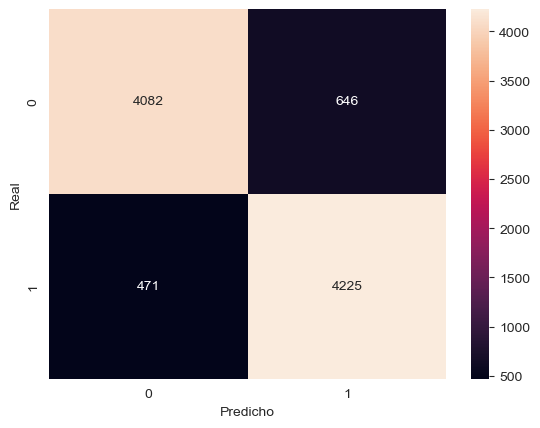

In [285]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble voting')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [294]:
prediccion_train = ensamble_voting.predict(x_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.908106960950764
Recall: 0.9245063264333739
Precision: 0.8954925388441618
f1 score: 0.9097681687939567


#### Stacking Classifier

Para este caso vamos a probar dos variantes, uno con regresion logistica de metamodelo y otro con un random forest. 

##### Regresion logistica como metamodelo

In [ ]:
estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), 
              ('mnb', modelo_bernoulli), ('rfc', modelo_random_forest), ('mnb2', modelo_bernoulli)]

metamodel = LogisticRegression(random_state=33, max_iter=1000, n_jobs=-1, solver="newton-cholesky", penalty='l2', C=0.3)

ensamble_stacking = StackingClassifier(estimators=estimators, final_estimator=metamodel, cv=5)
ensamble_stacking.fit(x_train, y_train)

prediccion = ensamble_stacking.predict(x_test)
mostrar_scores(y_test, prediccion)

In [ ]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble stacking con lr como metamodelo')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
prediccion_train = ensamble_stacking.predict(x_train)

mostrar_scores(y_train, prediccion_train)

##### Random forest como metamodelo

In [ ]:
estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), 
              ('mnb', modelo_bernoulli), ('rfc', modelo_random_forest), ('mnb2', modelo_bernoulli)]

metamodel = RandomForestClassifier(
    criterion='entropy',
    n_jobs=-1,
    random_state=42,
    n_estimators=1000,
)

ensamble_stacking = StackingClassifier(estimators=estimators, final_estimator=metamodel, cv=5)
ensamble_stacking.fit(x_train, y_train)

prediccion = ensamble_stacking.predict(x_test)
mostrar_scores(y_test, prediccion)

In [ ]:
tabla = confusion_matrix(y_test, prediccion)
sns.heatmap(tabla, annot=True, fmt='d').set_title('Matriz de confusión ensamble stacking con rf como metamodelo')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
prediccion_train = ensamble_stacking.predict(x_train)

mostrar_scores(y_train, prediccion_train)

#### Prediccion en los datos de test

In [290]:
df_test = pd.read_csv('datasets/test.csv', sep=',')
df_test_copia = df_test.copy()

df_test_copia['review_es'] = df_test_copia['review_es'].apply(demojize)
df_test_copia['review_es'] = df_test_copia['review_es'].apply(tokenize)

prediccion = ensamble_voting.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('voting_Nbx2_rf_xg_lr.csv', index=False)